In [1]:
import os.path as op

import matplotlib.pyplot as plt
from matplotlib import patches

import seaborn as sns

import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy.stats import ttest_ind, ttest_rel, pearsonr

from neurodsp.utils.norm import normalize_sig

from timescales.fit import PSD
from timescales.autoreg import compute_ar_spectrum
from timescales.conversions import convert_knee
from timescales.plts import set_default_rc
from timescales.utils import create_windows

set_default_rc()

# Figure 4. Sleep vs. Wake
The timescales, as knee frequencies, are compared between 4 types of spike trains and the local field potential:

- Wake : Excitatory Units
- NREM : Excitatory Units
- Wake : Inhibitory Units
- NREM : Inhibitory Units


- LFP Wake
- LFP NREM

In [2]:
def compute_spectra_trials(spikes_e, spikes_i, start_end, f_range,
                           bin_size, ar_order, kwargs_ar=None):
    """Compute Welch's and AR PSD for exciatatory and inhibitory spikes."""
    
    # Ensure unpackable
    if kwargs_ar is None:
        kwargs_ar = {}
            
    # Compute AR-PSD and Welch's-PSD for each window
    for ind, (s, e) in enumerate(start_end):

        # Normalize
        spikes_bin_e = normalize_sig(
            spikes_e[s:e].reshape(-1, bin_size).sum(axis=1), 0, 1)
        
        spikes_bin_i = normalize_sig(
            spikes_i[s:e].reshape(-1, bin_size).sum(axis=1), 0, 1)
        
        # Compute excitatory spectra
        freqs_ar, powers_ar_e = compute_ar_spectrum(spikes_bin_e, fs/bin_size, ar_order,
                                                    f_range=f_range, **kwargs_ar)
        
        # Compute inhibitory spectra
        _, powers_ar_i = compute_ar_spectrum(spikes_bin_i, fs/bin_size, ar_order,
                                             f_range=f_range, **kwargs_ar)
        
        # Initalize arrays
        if ind == 0:
            
            freqs = {'ar': freqs_ar}
            
            powers = {
                'ar': {'excitatory': np.zeros((len(start_end), len(powers_ar_e))),
                       'inhibitory': np.zeros((len(start_end), len(powers_ar_i)))}
            }
            
        powers['ar']['excitatory'][ind] = powers_ar_e
        powers['ar']['inhibitory'][ind] = powers_ar_i
        
    return freqs, powers

In [3]:
# Load data
base_name = '20140526_277um'
dir_path = f'/home/rphammonds/projects/timescale-methods/fcx1/data/{base_name}'

subtype_dict = loadmat(f'{dir_path}/{base_name}_SSubtypes.mat')
subtype_e = subtype_dict['Se_CellFormat'][0]
subtype_i = subtype_dict['Si_CellFormat'][0]

fs = 20000

n_seconds = np.ceil(max([*[np.max(i) for i in subtype_i], 
                         *[np.max(i) for i in subtype_e]]))

times = np.arange(0, n_seconds, 1/fs)

# Extract behavioral data
beh_file = f'{dir_path}/{base_name}_WSRestrictedIntervals.mat'
beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) *  fs

# Window by trial type
win_len = int(5*fs)
win_spacing = int(5*fs)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

start_end_wake = np.vstack((wake_starts, wake_ends)).T
start_end_nrem = np.vstack((nrem_starts, nrem_ends)).T

In [4]:
# Load LFP
data_dir = f'/home/rphammonds/projects/timescale-methods/fcx1/data_mats/{base_name}'
fs_lfp = 1250

# Infer shape using one channel
lfp_file = op.join(data_dir, 'data01.mat')
sig_len = len(loadmat(lfp_file)['data'][0])

# Get PFC channels
channels = list(range(17, 49))
sig_lfp = np.zeros(sig_len)

for cind, ch in enumerate(channels):
    lfp_file = op.join(data_dir, f'data{ch}.mat')
    sig_lfp += loadmat(lfp_file)['data'][0]

sig_lfp = sig_lfp / len(channels)
sig_lfp =  normalize_sig(sig_lfp, 0, 1)

times = np.arange(0, len(sig_lfp)/fs_lfp, 1/fs_lfp)

# Windows
nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs_lfp
wake = beh['WakeTimePairFormat'].astype(int) * fs_lfp

# Window by trial type
win_len = int(5*fs_lfp)
win_spacing = int(5*fs_lfp)

wake_starts, wake_mids, wake_ends = create_windows(wake, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem, win_len, win_spacing)

start_end_wake_lfp = np.vstack((wake_starts, wake_ends)).T
start_end_nrem_lfp = np.vstack((nrem_starts, nrem_ends)).T

# Create 2d arrays
sig_lfp_wake = np.array([sig_lfp[s:e] for s, e in
                         zip(wake_starts, wake_ends)])

sig_lfp_nrem = np.array([sig_lfp[s:e] for s, e in
                         zip(nrem_starts, nrem_ends)])

### Fit Spikes

In [5]:
# Sum spikes across E/I sub-units
spikes = np.zeros((2, int(n_seconds * fs)))
                    
for sind, subtype in enumerate([subtype_e, subtype_i]):
    for s in subtype:
        spikes[sind, (s[:, 0] * fs).astype(int)] = 1

spikes_e = spikes[0]
spikes_i = spikes[1]

# Compute Spectra
f_range = (0, 100)
bin_size = 100
ar_order = 10

freqs_wake, powers_wake = compute_spectra_trials(
    spikes_e, spikes_i, start_end_wake, f_range, bin_size, ar_order
)

freqs_nrem, powers_nrem = compute_spectra_trials(
    spikes_e, spikes_i, start_end_nrem, f_range, bin_size, ar_order
)

In [6]:
sigma = np.logspace(-2, 0, 2000)

psd_ex_nrem = PSD(freqs_nrem['ar'], powers_nrem['ar']['excitatory'])
psd_ex_nrem.fit(method='huber', n_resample=2000, sigma=sigma, #bounds=bounds, guess=guess,
                f_range=(1e-3, 10), n_jobs=-1, progress='tqdm.notebook')

psd_in_nrem = PSD(freqs_nrem['ar'], powers_nrem['ar']['inhibitory'])
psd_in_nrem.fit(method='huber', n_resample=2000, sigma=sigma, #bounds=bounds, guess=guess,
                f_range=(1e-3, 10), n_jobs=-1, progress='tqdm.notebook')

psd_ex_wake = PSD(freqs_wake['ar'], powers_wake['ar']['excitatory'])
psd_ex_wake.fit(method='huber', n_resample=2000, sigma=sigma, #bounds=bounds, guess=guess,
                f_range=(1e-3, 10), n_jobs=-1, progress='tqdm.notebook')

psd_in_wake = PSD(freqs_wake['ar'], powers_wake['ar']['inhibitory'])
psd_in_wake.fit(method='huber', n_resample=2000, sigma=sigma, #bounds=bounds, guess=guess,
                f_range=(1e-3, 10), n_jobs=-1, progress='tqdm.notebook')

psd_ex_nrem.tau *= 1000
psd_in_nrem.tau *= 1000

psd_ex_wake.tau *= 1000
psd_in_wake.tau *= 1000

Fitting PSD:   0%|                                                                 | 0/536 [00:00<?, ?it/s]

Fitting PSD:   0%|                                                                 | 0/536 [00:00<?, ?it/s]

Fitting PSD:   0%|                                                                 | 0/427 [00:00<?, ?it/s]

Fitting PSD:   0%|                                                                 | 0/427 [00:00<?, ?it/s]

### Fit LFPs

In [7]:
# Fit LFP models
bounds = [
    [-10, 1e-3, 1e-3, 1e-20],
    [ 10, 20,     10,  1e-2]
]

guess = [-2, 1, 1, 1e-2]

psd_lfp_wake = PSD()
psd_lfp_wake.compute_spectrum(sig_lfp_wake, fs_lfp, f_range=(0, 100), ar_order=10)
psd_lfp_wake.fit(method='huber', n_resample=2000, sigma=sigma, #bounds=bounds, guess=guess,
                 f_range=(1e-3, 10), n_jobs=-1, progress='tqdm.notebook')

psd_lfp_nrem = PSD()
psd_lfp_nrem.compute_spectrum(sig_lfp_nrem, fs_lfp, f_range=(0, 100), ar_order=10)
psd_lfp_nrem.fit(method='huber', n_resample=2000, sigma=sigma, #bounds=bounds, guess=guess,
                 f_range=(1e-3, 10), n_jobs=-1, progress='tqdm.notebook')

psd_lfp_nrem.tau *= 1000
psd_lfp_wake.tau *= 1000

Fitting PSD:   0%|                                                                 | 0/427 [00:00<?, ?it/s]

Fitting PSD:   0%|                                                                 | 0/536 [00:00<?, ?it/s]

### Stats

In [8]:
df_summary = pd.DataFrame()

df_summary['group'] = ['Wake : LFP', 'NREM : LFP', 'Wake : Spikes E',
                       'NREM : Spikes E', 'Wake : Spikes I', 'NREM : Spikes I']

df_summary['mean_tau'] = [
    psd_lfp_wake.tau.mean(), psd_lfp_nrem.tau.mean(),
    psd_ex_wake.tau.mean(), psd_ex_nrem.tau.mean(),
    psd_in_wake.tau.mean(), psd_in_nrem.tau.mean()
]

df_summary['sd_tau'] = [
    psd_lfp_wake.tau.std(), psd_lfp_nrem.tau.std(),
    psd_ex_wake.tau.std(), psd_ex_nrem.tau.std(),
    psd_in_wake.tau.std(), psd_in_nrem.tau.std()
]

df_summary['mean_rsq'] = [
    psd_lfp_wake.rsq.mean(), psd_lfp_nrem.rsq.mean(),
    psd_ex_wake.rsq.mean(), psd_ex_nrem.rsq.mean(),
    psd_in_wake.rsq.mean(), psd_in_nrem.rsq.mean()
]

df_summary['sd_rsq'] = [
    psd_lfp_wake.rsq.std(), psd_lfp_nrem.rsq.std(),
    psd_ex_wake.rsq.std(), psd_ex_nrem.rsq.std(),
    psd_in_wake.rsq.std(), psd_in_nrem.rsq.std()
]

# Compares wake vs non-rem
df_stats = pd.DataFrame()

data = {'lfp': {'tau': {'wake': psd_lfp_wake.tau, 'nrem': psd_lfp_nrem.tau},
                'rsq': {'wake': psd_lfp_wake.rsq, 'nrem': psd_lfp_nrem.rsq}},
        'spike_ex': {'tau':  {'wake': psd_ex_wake.tau,  'nrem': psd_ex_nrem.tau},
                     'rsq':  {'wake': psd_ex_wake.rsq,  'nrem': psd_ex_nrem.rsq}},
        'spike_in': {'tau':  {'wake': psd_in_wake.tau,  'nrem': psd_in_nrem.tau},
                     'rsq':  {'wake': psd_in_wake.rsq,  'nrem': psd_in_nrem.rsq}}}

labels = []
ts = []
ps = []

for dtype in ['lfp', 'spike_ex', 'spike_in']:

    for meas in ['tau', 'rsq']:
        
        t, p = ttest_ind(data[dtype][meas]['wake'], data[dtype][meas]['nrem'])
        ts.append(t)
        ps.append(p)
        labels.append(f'{dtype}_{meas}')
    
df_stats_wake_v_nrem = pd.DataFrame()  
df_stats_wake_v_nrem['labels'] = labels
df_stats_wake_v_nrem['t-stat'] = ts
df_stats_wake_v_nrem['p-val'] = ps

# Compares inhibitory vs excitatory spikes
labels = []
ts = []
ps = []


for trial in ['wake', 'nrem']:
    for meas in ['tau', 'rsq']:
        t, p = ttest_ind(data['spike_ex'][meas][trial], data['spike_in'][meas][trial])
        ts.append(t)
        ps.append(p)
        labels.append(f'{trial}_{meas}')

df_stats_ex_vs_in = pd.DataFrame()
df_stats_ex_vs_in['labels'] = labels
df_stats_ex_vs_in['t-stat'] = ts
df_stats_ex_vs_in['p-val'] = ps

In [9]:
df_summary

,group,mean_tau,sd_tau,mean_rsq,sd_rsq
0,Wake : LFP,27.268058,11.928761,0.999968,0.000171
1,NREM : LFP,85.519407,33.881954,0.999587,0.003726
2,Wake : Spikes E,26.955050,8.330868,0.980621,0.102404
3,NREM : Spikes E,35.461686,10.819548,0.996833,0.041134
4,Wake : Spikes I,32.024438,12.009980,0.987104,0.094115
5,NREM : Spikes I,44.573614,14.726774,0.997022,0.038176


In [10]:
df_stats_wake_v_nrem

,labels,t-stat,p-val
0,lfp_tau,-33.857235,4.888160e-166
1,lfp_rsq,2.106736,3.539917e-02
2,spike_ex_tau,-13.375557,1.525106e-37
3,spike_ex_rsq,-3.338859,8.735554e-04
4,spike_in_tau,-14.221625,8.513135e-42
5,spike_in_rsq,-2.218891,2.672712e-02


In [11]:
df_stats_ex_vs_in

,labels,t-stat,p-val
0,wake_tau,-7.158400,1.762660e-12
1,wake_rsq,-0.962062,3.362915e-01
2,nrem_tau,-11.533274,4.336823e-29
3,nrem_rsq,-0.078046,9.378061e-01


In [12]:
# Merge taus
taus_nrem = np.concatenate([
    psd_lfp_nrem.tau, psd_ex_nrem.tau, psd_in_nrem.tau,
])

taus_wake = np.concatenate([
    psd_lfp_wake.tau, psd_ex_wake.tau, psd_in_wake.tau
])

# Merge labels
labels_nrem = [
    *['LFP\n'] * len(psd_lfp_nrem.tau),
    *['Spikes\nExcitatory\n'] * len(psd_ex_nrem.tau),
    *['Spikes\nInhibitory\n'] * len(psd_in_nrem.tau)
]

labels_wake = [
    *['LFP\n'] * len(psd_lfp_wake.tau),
    *['Spikes\nExcitatory\n'] * len(psd_ex_wake.tau),
    *['Spikes\nInhibitory\n'] * len(psd_in_wake.tau)
]

# To dataframe
df_nrem = pd.DataFrame(dict(taus=taus_nrem, labels=labels_nrem))
df_wake = pd.DataFrame(dict(taus=taus_wake, labels=labels_wake))

# Merge
taus_nrem = np.zeros(len(df_nrem) + len(df_wake))
taus_wake = np.zeros(len(df_nrem) + len(df_wake))

taus_nrem[len(df_nrem):] = None
taus_wake[:len(df_nrem)] = None

# Knee freq to tau (ms)
taus_nrem[:len(df_nrem)] = df_nrem['taus'].values
taus_wake[len(df_nrem):] = df_wake['taus'].values

labels_nrem = np.zeros(len(df_nrem) + len(df_wake), dtype=object)
labels_nrem[:len(df_nrem)] = df_nrem['labels'].values
labels_nrem[len(df_nrem):] = None

labels_wake = np.zeros(len(df_nrem) + len(df_wake), dtype=object)
labels_wake[len(df_nrem):] = df_wake['labels'].values
labels_wake[:len(df_nrem)] = None

labels = np.zeros(len(df_nrem) + len(df_wake), dtype=object)
labels[len(df_nrem):] = df_wake['labels'].values
labels[:len(df_nrem)] = df_nrem['labels'].values

df = pd.DataFrame()

df['taus_nrem'] = taus_nrem
df['taus_wake'] = taus_wake
df['labels_nrem'] = labels_nrem
df['labels_wake'] = labels_wake
df['labels'] = labels

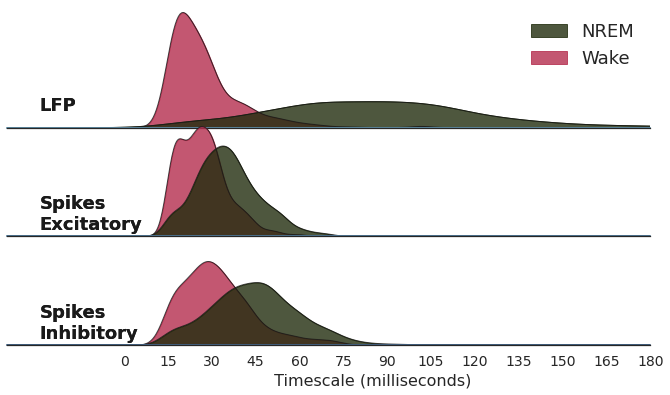

In [13]:
colors = ['#222D0E', '#B52E4E']

overlap_hspace = -.1
xlim = (-40, 180)
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(6, rot=-.25, light=.5)

grid = sns.FacetGrid(df, row="labels", hue="labels", aspect=5, height=2, palette=pal, xlim=xlim)

# Draw the densities in a few steps
grid.map(sns.kdeplot, "taus_wake", clip_on=True, fill=True, alpha=.8, linewidth=1, color=colors[1])
grid.map(sns.kdeplot, "taus_nrem", clip_on=True, fill=True, alpha=.8, linewidth=1, color=colors[0])


grid.map(sns.kdeplot, "taus_wake", clip_on=True, color="k", alpha=.8, lw=1, bw_adjust=1)
grid.map(sns.kdeplot, "taus_nrem", clip_on=True, color="k", alpha=.8, lw=1, bw_adjust=1)


grid.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.05, .1, label, fontweight="bold", color='k',
            ha="left", va="center", transform=ax.transAxes, size=18)

grid.map(label, "taus_nrem")
grid.map(label, "taus_wake")

# Set the subplots to overlap
grid.figure.subplots_adjust(hspace=overlap_hspace)

# Remove axes details that don't play well with overlap
grid.set_titles("")
grid.set(yticks=[], ylabel="")
grid.set(xticks=np.linspace(0, xlim[1], 13).astype(int))
grid.despine(bottom=False, left=True)

grid.set_xticklabels(np.linspace(0, xlim[1], 13).astype(int), size=14)
grid.set_xlabels('                 Timescale (milliseconds)', size=16)

# There is no labels, need to define the labels
legend_labels  = ['NREM', 'Wake']

# Create the legend patches
legend_patches = [patches.Patch(color=c, label=l, alpha=.8) for c, l in
                  zip(colors, legend_labels)]

# Plot the legend
grid.axes[0][0].legend(handles=legend_patches, loc='upper right',
                       framealpha=0, fontsize=18)

# Save
plt.savefig('fig05_sleep_vs_wake.png', dpi=300, facecolor='w');